

# Bayesian Estimation of Differential Equations

Most of the scientific community deals with the basic problem of trying to mathematically model the reality around them and this often involves dynamical systems. The general trend to model these complex dynamical systems is through the use of differential equations. Differential equation models often have non-measurable parameters. The popular “forward-problem” of simulation consists of solving the differential equations for a given set of parameters, the “inverse problem” to simulation, known as parameter estimation, is the process of utilizing data to determine these model parameters. Bayesian inference provides a robust approach to parameter estimation with quantified uncertainty.

In [1]:
using Turing, Distributions, DataFrames, DifferentialEquations, DiffEqSensitivity

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Disable Turing's progress meter for this tutorial.
Turing.turnprogress(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/cameron/.julia/packages/Turing/GMBTf/src/Turing.jl:22


false

## The Lotka-Volterra Model

The Lotka–Volterra equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey. The populations change through time according to the pair of equations:

$\frac{dx}{dt} = (\alpha - \beta y)x$
 
$\frac{dy}{dt} = (\delta x - \gamma)y$


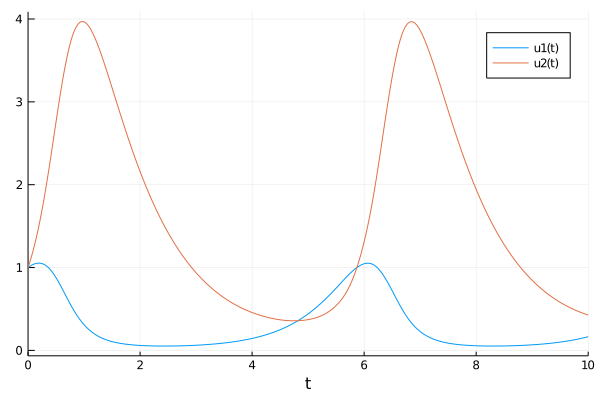

In [2]:
function lotka_volterra(du,u,p,t)
  x, y = u
  α, β, δ, γ = p
  du[1] = dx = (α - β*y)x
  du[2] = dy = (δ*x - γ)y
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob,Tsit5())
plot(sol)

We'll generate the data to use for the parameter estimation from simulation. 
With the `saveat` [argument](https://docs.sciml.ai/latest/basics/common_solver_opts/) we specify that the solution is stored only at `0.1` time units. 

In [3]:
sol = solve(prob,Tsit5(),saveat=0.1)
odedata = hcat([sol[:,i] .+ 0.01randn(2) for i in 1:size(sol,2)]...) 

2×101 Array{Float64,2}:
 0.997817  1.04585  1.07345  1.03149  …  0.122743  0.150842  0.163405
 0.982782  1.22727  1.53151  1.88856     0.489111  0.449427  0.423763

## Fitting Lotka-Volterra with DiffEqBayes

[DiffEqBayes.jl](https://github.com/SciML/DiffEqBayes.jl) is a high level package that set of extension functionality for estimating the parameters of differential equations using Bayesian methods. It allows the choice of using CmdStan.jl, Turing.jl, DynamicHMC.jl and ApproxBayes.jl to perform a Bayesian estimation of a differential equation problem specified via the DifferentialEquations.jl interface. You can read the [docs](https://docs.sciml.ai/latest/analysis/parameter_estimation/#Bayesian-Methods-1) for an understanding of the available functionality.

In [4]:
using DiffEqBayes
t = 0:0.1:10.0
priors = [truncated(Normal(1.5,0.5),0.5,2.5),truncated(Normal(1.2,0.5),0,2),truncated(Normal(3.0,0.5),1,4),truncated(Normal(1.0,0.5),0,2)]
bayesian_result_turing = turing_inference(prob,Tsit5(),t,odedata,priors,num_samples=10_000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/cameron/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629


Object of type Chains, with data of type 9000×17×1 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = theta[1], theta[2], theta[3], theta[4], σ[1]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
    theta[1]  1.5009  0.0081    0.0001  0.0001  2834.1174  0.9999
    theta[2]  1.0002  0.0050    0.0001  0.0001  2936.2756  0.9999
    theta[3]  3.0020  0.0063    0.0001  0.0001  4416.7504  0.9999
    theta[4]  0.9996  0.0044    0.0000  0.0001  2824.1604  0.9999
        σ[1]  0.0204  0.0013    0.0000  0.0000  4162.0540  1.0000

Quantiles
  parameters    2.5%   25.0%   50.0%  

The estimated parameters are clearly very close to the desired parameter values. We can also check that the chains have converged in the plot.

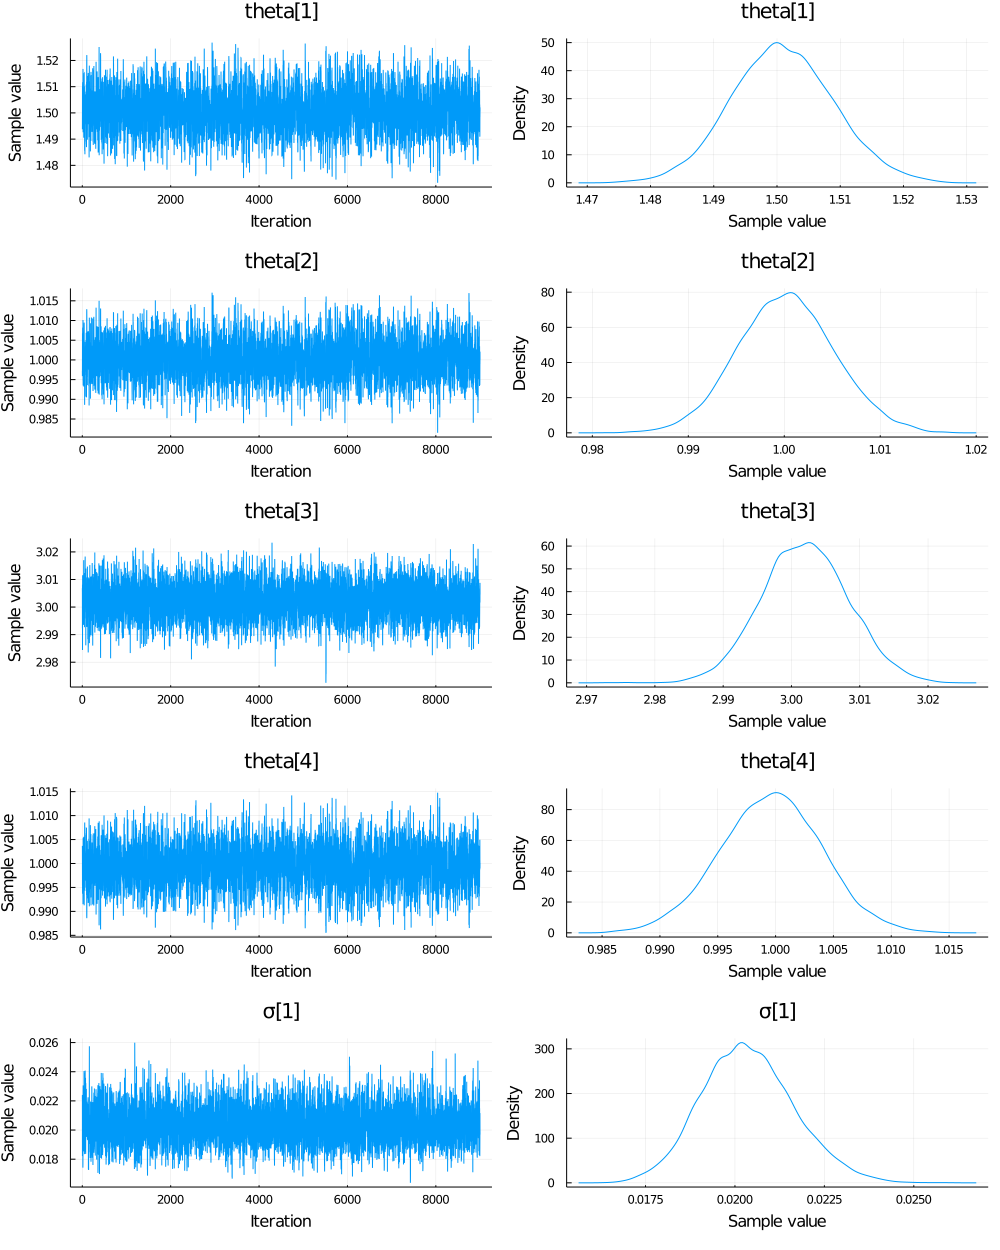

In [5]:
plot(bayesian_result_turing)

## Direct Handling of Bayesian Estimation with Turing

You could want to do some sort of reduction with the differential equation's solution or use it in some other way as well. In those cases DiffEqBayes might not be useful. Turing and DifferentialEquations are completely composable and you can write of the differential equation inside a Turing `@model` and it will just work.

We can rewrite the Lotka Volterra parameter estimation problem with a Turing `@model` interface as below

In [6]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata)
chain = sample(model, NUTS(.65),10000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/cameron/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629


Object of type Chains, with data of type 9000×17×1 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
           α  1.5006  0.0078    0.0001  0.0002  2436.2971  1.0001
           β  1.0000  0.0049    0.0001  0.0001  2546.3374  1.0000
           γ  3.0019  0.0062    0.0001  0.0001  4010.7689  0.9999
           δ  0.9997  0.0042    0.0000  0.0001  2414.2788  1.0001
           σ  0.0203  0.0013    0.0000  0.0000  4768.2941  1.0000

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──

## Scaling to Large Models: Adjoint Sensitivities

DifferentialEquations.jl's efficiency for large stiff models has been shown in multiple [benchmarks](https://github.com/SciML/DiffEqBenchmarks.jl). To learn more about how to optimize solving performance for stiff problems you can take a look at the [docs](https://docs.sciml.ai/latest/tutorials/advanced_ode_example/). 

[Sensitivity analysis](https://docs.sciml.ai/latest/analysis/sensitivity/), or automatic differentiation (AD) of the solver, is provided by the DiffEq suite. The model sensitivities are the derivatives of the solution $u(t)$ with respect to the parameters. Specifically, the local sensitivity of the solution to a parameter is defined by how much the solution would change by changes in the parameter. Sensitivity analysis provides a cheap way to calculate the gradient of the solution which can be used in parameter estimation and other optimization tasks.


The AD ecosystem in Julia allows you to switch between forward mode, reverse mode, source to source and other choices of AD and have it work with any Julia code. For a user to make use of this within [SciML](https://sciml.ai), [high level interactions in `solve`](https://docs.sciml.ai/latest/analysis/sensitivity/#High-Level-Interface:-sensealg-1) automatically plug into those AD systems to allow for choosing advanced sensitivity analysis (derivative calculation) [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1). 

More theoretical details on these methods can be found at: https://docs.sciml.ai/latest/extras/sensitivity_math/.

While these sensitivity analysis methods may seem complicated (and they are!), using them is dead simple. Here is a version of the Lotka-Volterra model with adjoints enabled.

All we had to do is switch the AD backend to one of the adjoint-compatible backends (ReverseDiff, Tracker, or Zygote) and boom the system takes over and we're using adjoint methods! Notice that on this model adjoints are slower. This is because adjoints have a higher overhead on small parameter models and we suggest only using these methods for models with around 100 parameters or more. For more details, see https://arxiv.org/abs/1812.01892.

In [7]:
Turing.setadbackend(:zygote)
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1)
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/cameron/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


Object of type Chains, with data of type 500×17×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.5007  0.0083    0.0004  0.0004  125.1112  0.9983
           β  1.0001  0.0051    0.0002  0.0002  143.4142  0.9983
           γ  3.0020  0.0064    0.0003  0.0005  118.3848  1.0005
           δ  0.9997  0.0045    0.0002  0.0002  123.8078  0.9980
           σ  0.0205  0.0013    0.0001  0.0001  232.9602  1.0016

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ────

Now we can exercise control of the sensitivity analysis method that is used by using the `sensealg` keyword argument. Let's choose the `InterpolatingAdjoint` from the available AD [methods](https://docs.sciml.ai/latest/analysis/sensitivity/#Sensitivity-Algorithms-1) and enable a compiled ReverseDiff vector-Jacobian product:

In [8]:
@model function fitlv(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    p = [α,β,γ,δ]
    prob = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
    predicted = solve(prob,saveat=0.1,sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true)))
    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end;
model = fitlv(odedata)
@time chain = sample(model, NUTS(.65),1000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/cameron/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/s

229.728827 seconds (1.56 G allocations: 72.157 GiB, 5.61% gc time)


Object of type Chains, with data of type 500×17×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  2.3052  0.1128    0.0050  0.0038   77.0828  0.9981
           β  1.5337  0.1018    0.0046  0.0036   97.4806  0.9982
           γ  3.1633  0.2118    0.0095  0.0076  203.9501  0.9981
           δ  1.8515  0.0869    0.0039  0.0034   70.1302  0.9980
           σ  0.8609  0.0441    0.0020  0.0029  363.5746  1.0058

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ────

For more examples of adjoint usage on large parameter models, consult the [DiffEqFlux documentation](https://diffeqflux.sciml.ai/dev/)

## Including Process Noise: Estimation of Stochastic Differential Equations

This can be easily extended to Stochastic Differential Equations as well.

Let's create the Lotka Volterra equation with some noise and try out estimating it with the same framework we have set up before.

Our equations now become:

$dx = (\alpha - \beta y)xdt + \phi_1 xdW_1$

$dy = (\delta x - \gamma)ydt + \phi_2 ydW_2$

In [9]:
function lotka_volterra_noise(du,u,p,t)
    du[1] = p[5]*u[1]
    du[2] = p[6]*u[2]
end
p = [1.5, 1.0, 3.0, 1.0, 0.3, 0.3]
prob = SDEProblem(lotka_volterra,lotka_volterra_noise,u0,(0.0,10.0),p)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

Solving it repeatedly confirms the randomness of the solution

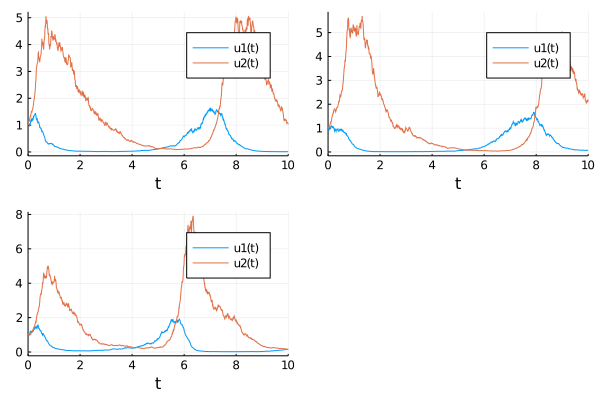

In [10]:
sol = solve(prob,saveat=0.01)
p1 = plot(sol)
sol = solve(prob,saveat=0.01)
p2 = plot(sol)
sol = solve(prob,saveat=0.01)
p3 = plot(sol)
plot(p1,p2,p3)

With the `MonteCarloSummary` it is easy to summarize the results from multiple runs through the `EnsembleProblem` interface, here we run the problem for 1000 `trajectories` and visualize the summary:

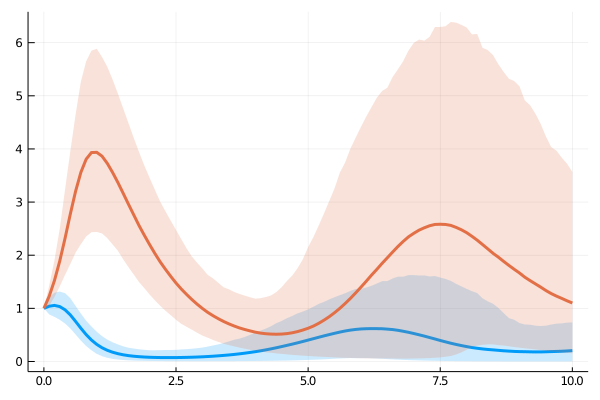

In [11]:
sol = solve(EnsembleProblem(prob),SRIW1(),saveat=0.1,trajectories=5000)
summ = EnsembleSummary(sol)
plot(summ)

Get data from the means to fit:

In [12]:
using DiffEqBase.EnsembleAnalysis
averagedata,real_vars = Array.(timeseries_steps_meanvar(sol))

([1.0 1.0400463884597635 … 0.1980843645146118 0.20460750978325976; 1.0 1.2277580575923053 … 1.1419830467137746 1.1005642508077889], [0.0 0.009726793312102511 … 0.08749259603623169 0.09099844682724174; 0.0 0.013490995782097384 … 1.9542962007288056 1.8883474637853068])

Now fit the means with Turing.

We will utilize multithreading with the [`EnsembleProblem`](https://docs.sciml.ai/stable/tutorials/sde_example/#Ensemble-Simulations-1) interface to speed up the SDE parameter estimation.

In [13]:
Threads.nthreads()

16

In [14]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data)
    σ1 ~ Normal()
    σ2 ~ Normal()
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)
    ϕ1 ~ truncated(Normal(1.2,0.5),0.1,1)
    ϕ2 ~ truncated(Normal(1.2,0.5),0.1,1)

    p = [α,β,γ,δ,ϕ1,ϕ2]
    prob = SDEProblem(lotka_volterra,lotka_volterra_noise,u0,(0.0,10.0),p)
    ensemble_predicted = solve(EnsembleProblem(prob),SRIW1(),saveat=0.1,trajectories=5000)
    predicted_means, predicted_vars = timeseries_steps_meanvar(ensemble_predicted)
    
    for i = 1:length(predicted_means)
        data[1][:,i] ~ MvNormal(predicted_means[i], σ1)
        data[2][:,i] ~ MvNormal(predicted_vars[i], σ2)
    end
end;

model = fitlv([averagedata,real_vars])
chain = sample(model, NUTS(.65), 500)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/cameron/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tru

Object of type Chains, with data of type 250×20×1 Array{Float64,3}

Iterations        = 1:250
Thinning interval = 1
Chains            = 1
Samples per chain = 250
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ1, σ2, ϕ1, ϕ2

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se    mcse     ess   r_hat
  ──────────  ───────  ──────  ────────  ──────  ──────  ──────
           α   1.5900  0.0000    0.0000  0.0000  2.0325  0.9960
           β   0.9260  0.0000    0.0000  0.0000  2.0325  2.5501
           γ   2.4580  0.0000    0.0000  0.0000  2.0325  2.9880
           δ   0.3176  0.0000    0.0000  0.0000  2.0325  1.3689
          σ1  -1.2667  0.0000    0.0000  0.0000  2.0325  2.6586
          σ2  -1.0054  0.0000    0.0000  0.0000     NaN     NaN
          ϕ1   0.365